# 1 导入库并查看数据

## 1.1 导入库

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.metrics import (roc_auc_score, precision_recall_curve, 
                           average_precision_score, confusion_matrix)
import lightgbm as lgb
import shap
%matplotlib inline

c:\Users\avawa\.conda\envs\ccfd\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 1.2 导入并查看数据

In [3]:
data = pd.read_csv('creditcard.csv')
print("数据维度:", data.shape)
data.head()

数据维度: (284807, 31)


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


# 2 数据预处理

## 2.1 时间特征工程

In [5]:
# 将Time转换为小时和分钟
data['Hour'] = data['Time'] // 3600 % 24
data['Minute'] = (data['Time'] // 60) % 60
data['Time_Diff'] = data['Time'].diff().fillna(0)  # 假设有UserID

In [6]:
# 周期性编码
data['Hour_sin'] = np.sin(2 * np.pi * data['Hour'] / 24)
data['Hour_cos'] = np.cos(2 * np.pi * data['Hour'] / 24)

## 2.2 检查数据分布

### 2.2.1 直方图

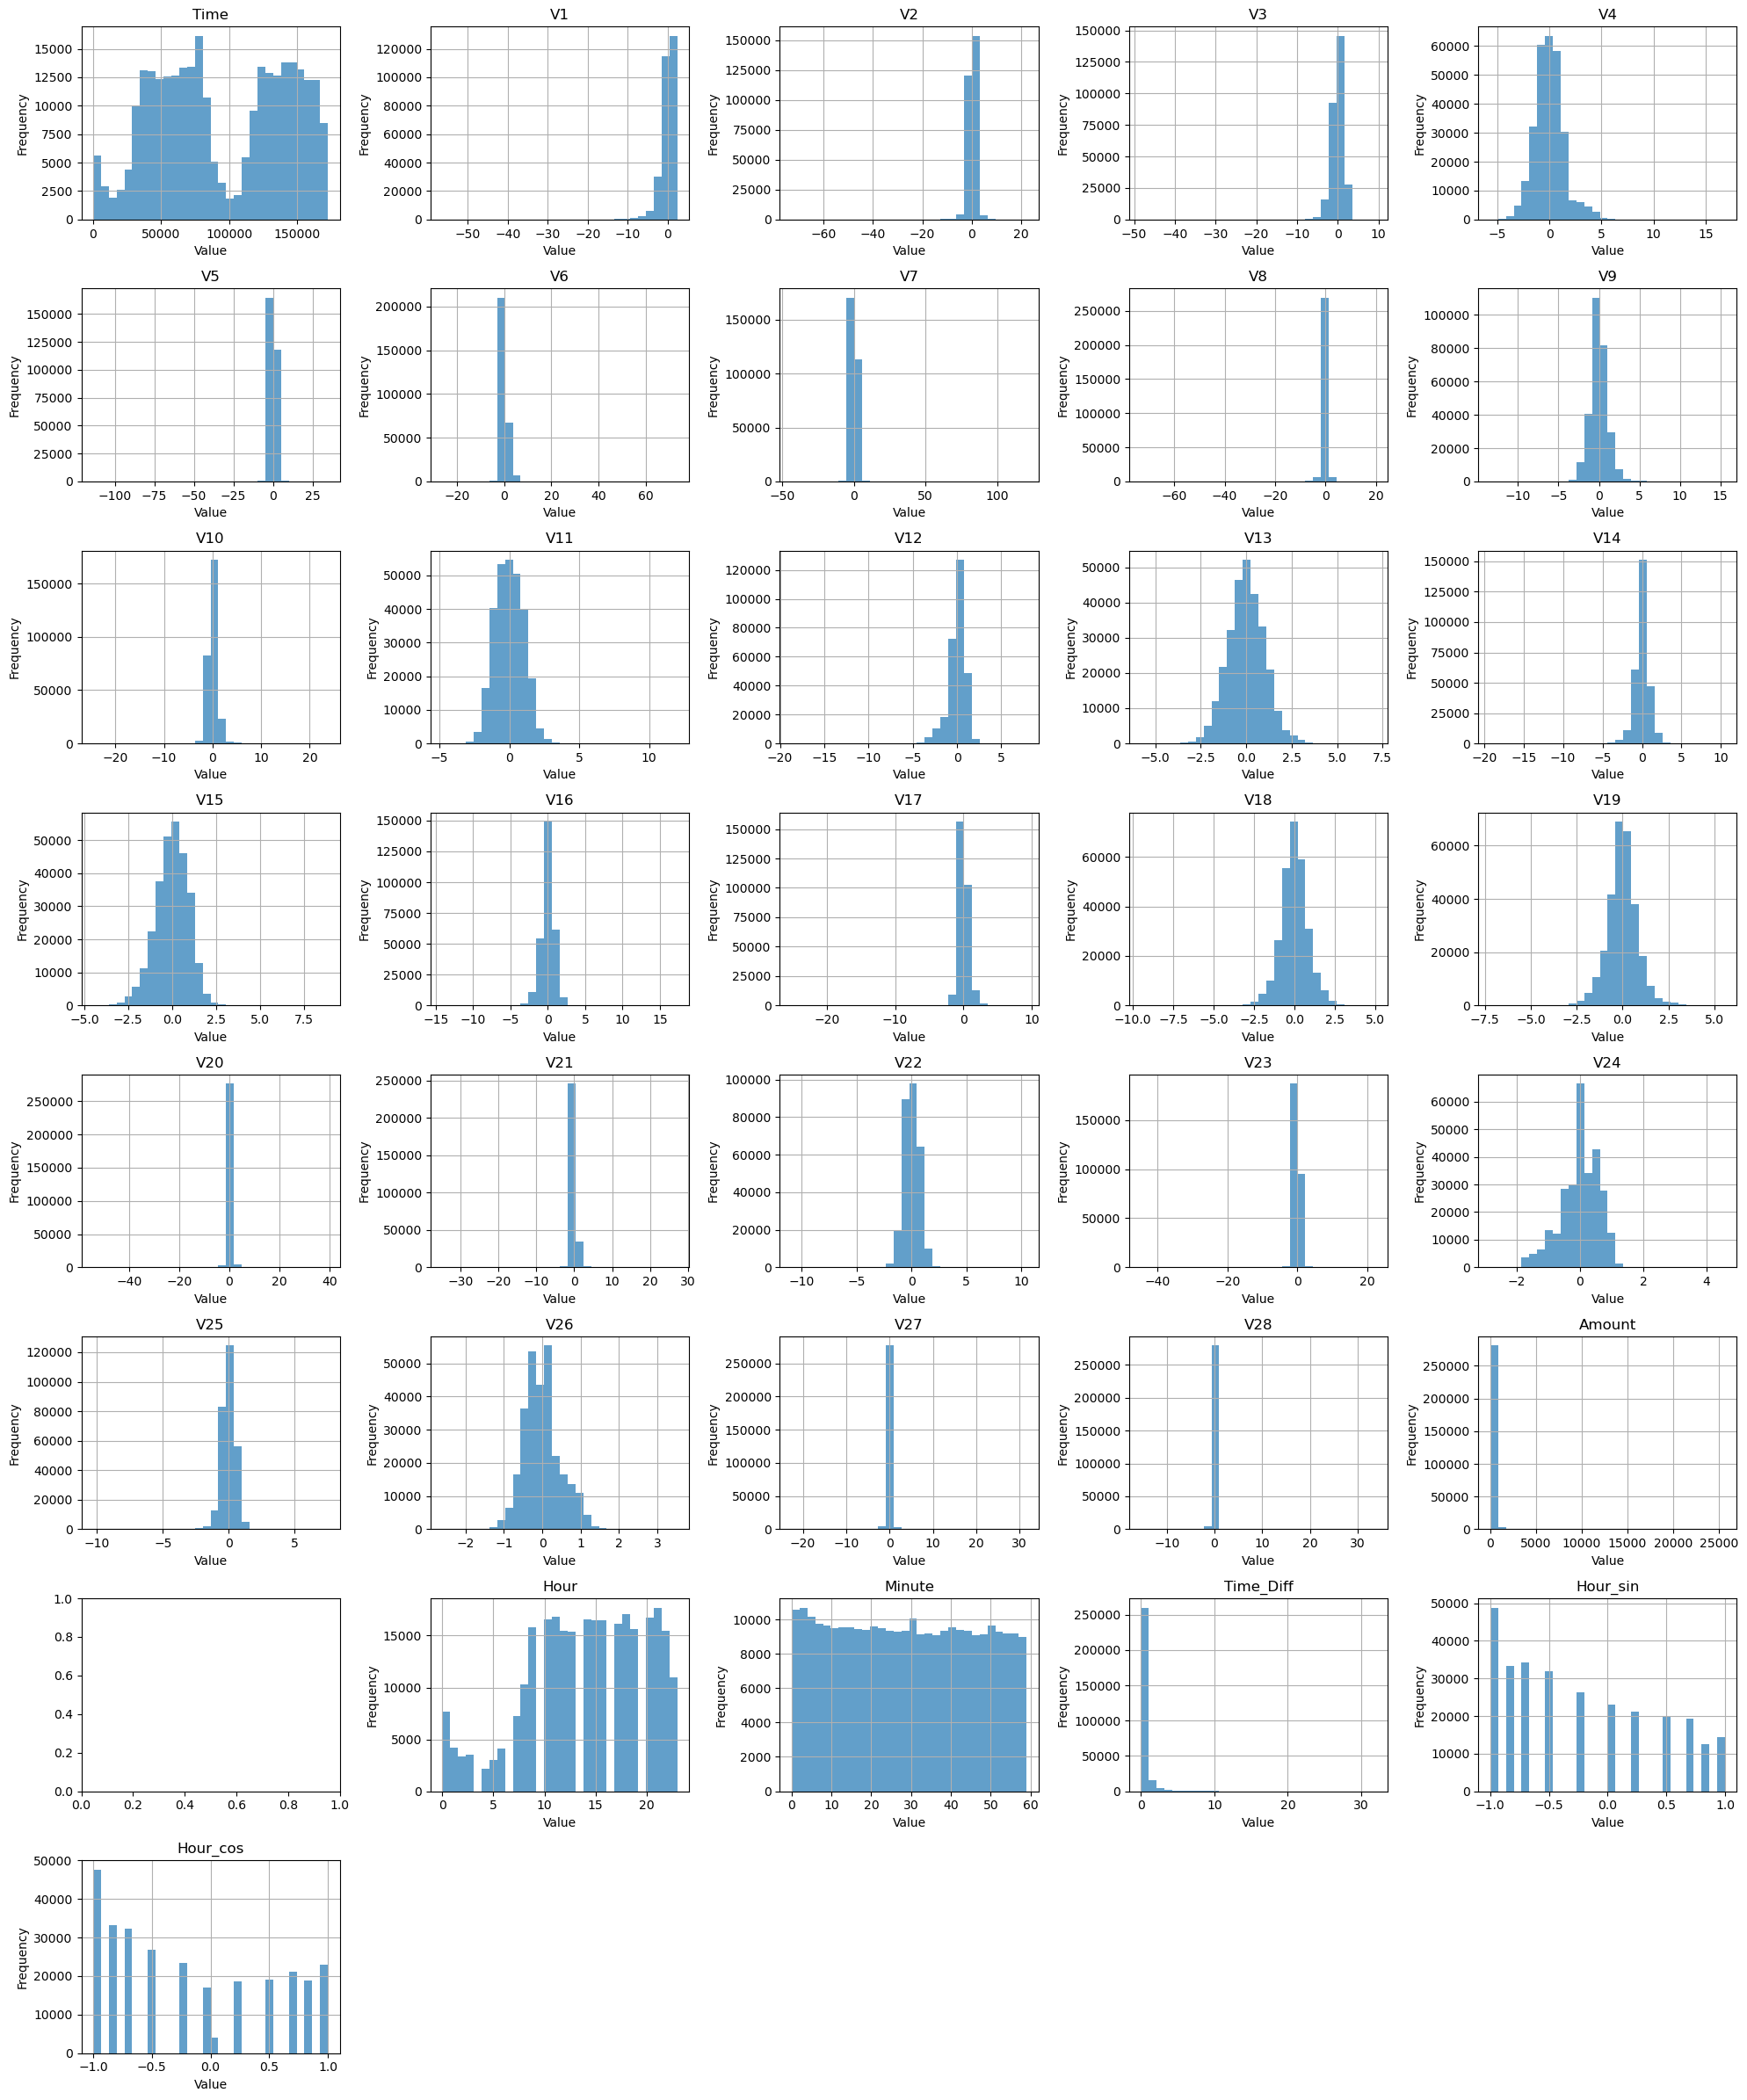

In [7]:
# 设置图形大小
num_features = len(data.columns)  # 特征数量
cols = 5  # 每行显示的图表数量
rows = (num_features + cols - 1) // cols  # 计算行数

fig, axes = plt.subplots(rows, cols, figsize=(cols * 4, rows * 3))  # 设置子图网格
axes = axes.flatten()  # 将子图对象展平，方便迭代

for i, column in enumerate(data.columns):
    if column != 'Class':  # 排除目标变量
        ax = axes[i]
        data[column].hist(bins=30, alpha=0.7, ax=ax)  # 绘制直方图
        ax.set_title(column)  # 设置标题
        ax.set_xlabel("Value")
        ax.set_ylabel("Frequency")

# 如果子图数量多于特征数量，隐藏多余的子图
for i in range(len(data.columns), len(axes)):
    axes[i].set_visible(False)

plt.tight_layout()  # 自动调整子图间距
plt.show()

### 2.2.2 密度图

C:\Users\avawa\AppData\Local\Temp\ipykernel_9116\1453106493.py:12: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(data[column], ax=ax, shade=True)  # 绘制密度图
C:\Users\avawa\AppData\Local\Temp\ipykernel_9116\1453106493.py:12: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(data[column], ax=ax, shade=True)  # 绘制密度图
C:\Users\avawa\AppData\Local\Temp\ipykernel_9116\1453106493.py:12: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(data[column], ax=ax, shade=True)  # 绘制密度图
C:\Users\avawa\AppData\Local\Temp\ipykernel_9116\1453106493.py:12: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will be

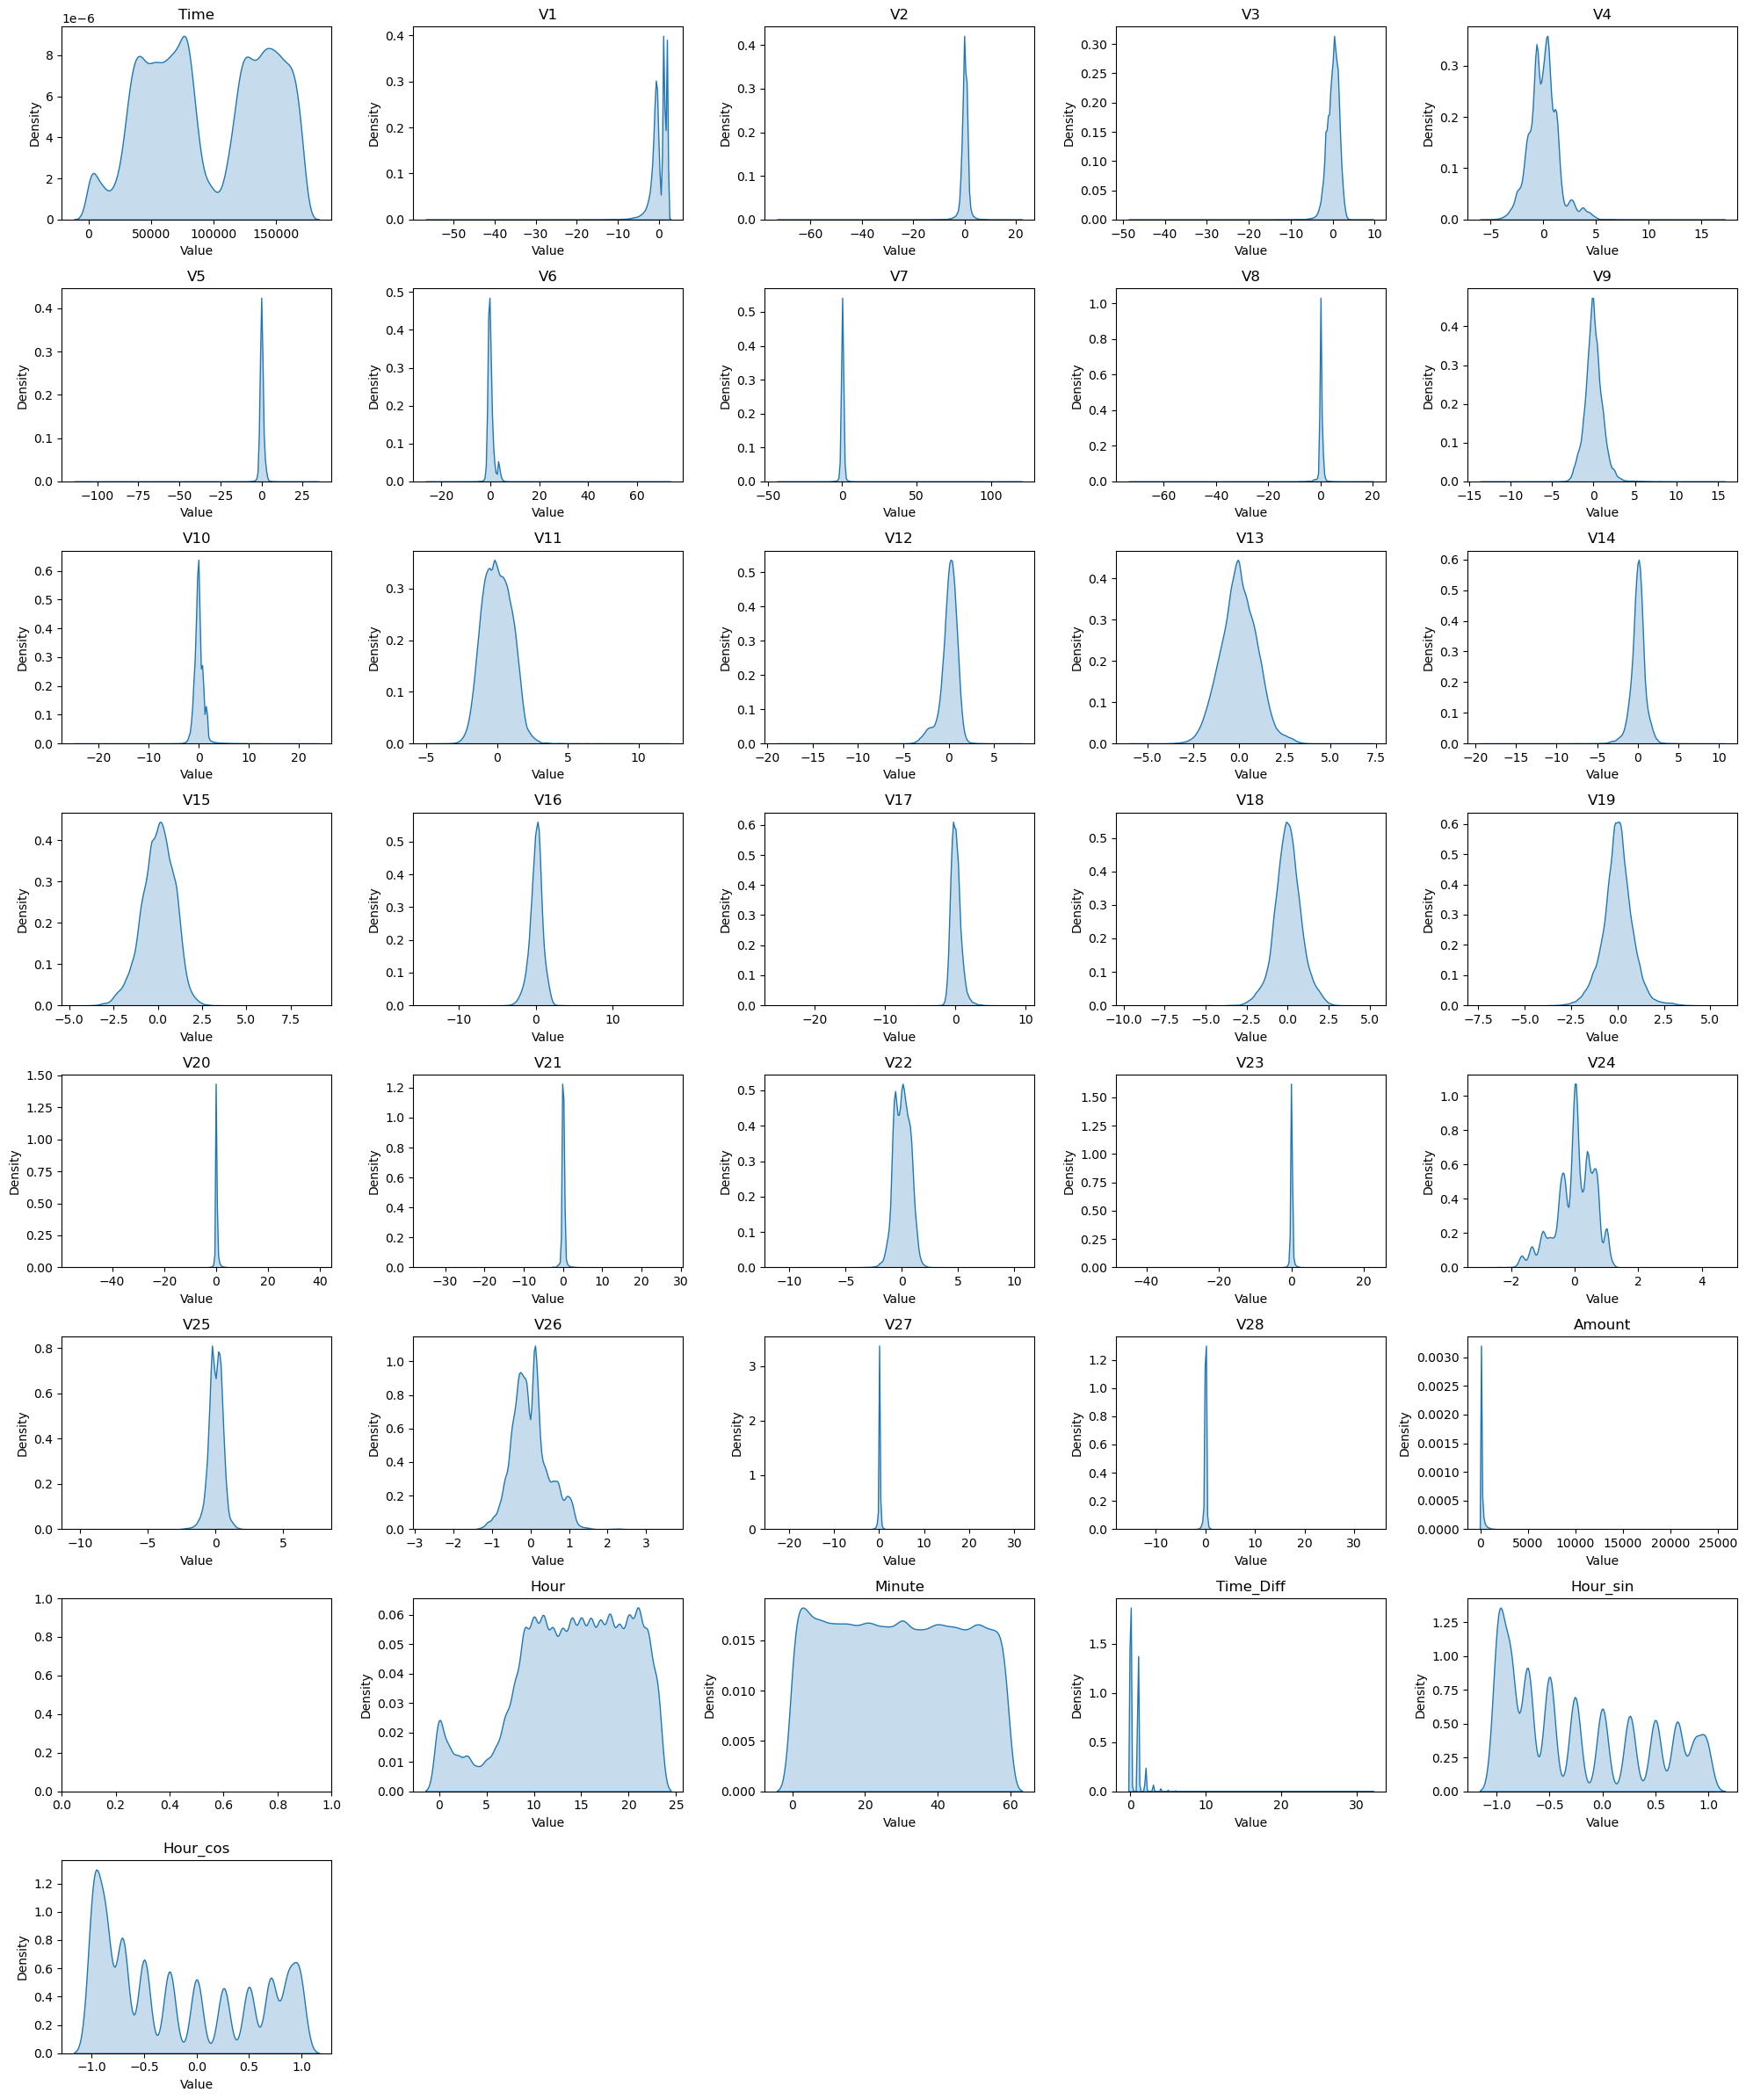

In [8]:
# 设置图形大小
num_features = len(data.columns)  # 特征数量
cols = 5  # 每行显示的图表数量
rows = (num_features + cols - 1) // cols  # 计算行数

fig, axes = plt.subplots(rows, cols, figsize=(cols * 4, rows * 3))  # 设置子图网格
axes = axes.flatten()  # 将子图对象展平以便于迭代

for i, column in enumerate(data.columns):
    if column != 'Class':  # 排除目标变量
        ax = axes[i]
        sns.kdeplot(data[column], ax=ax, shade=True)  # 绘制密度图
        ax.set_title(column)  # 设置标题
        ax.set_xlabel("Value")
        ax.set_ylabel("Density")

# 如果子图数量多于特征数量，隐藏多余的子图
for i in range(len(data.columns), len(axes)):
    axes[i].set_visible(False)

plt.tight_layout()  # 自动调整子图间距
plt.show()

# 3 数据可视化

## 3.1 欺诈交易时间模式分析

C:\Users\avawa\AppData\Local\Temp\ipykernel_9116\2067508527.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=fraud_hours.index, y=fraud_hours.values, palette='Reds')


Text(0.5, 1.0, '欺诈交易的小时分布')

c:\Users\avawa\.conda\envs\ccfd\lib\site-packages\IPython\core\events.py:82: UserWarning: Glyph 27450 (\N{CJK UNIFIED IDEOGRAPH-6B3A}) missing from font(s) DejaVu Sans.
  func(*args, **kwargs)
c:\Users\avawa\.conda\envs\ccfd\lib\site-packages\IPython\core\events.py:82: UserWarning: Glyph 35784 (\N{CJK UNIFIED IDEOGRAPH-8BC8}) missing from font(s) DejaVu Sans.
  func(*args, **kwargs)
c:\Users\avawa\.conda\envs\ccfd\lib\site-packages\IPython\core\events.py:82: UserWarning: Glyph 20132 (\N{CJK UNIFIED IDEOGRAPH-4EA4}) missing from font(s) DejaVu Sans.
  func(*args, **kwargs)
c:\Users\avawa\.conda\envs\ccfd\lib\site-packages\IPython\core\events.py:82: UserWarning: Glyph 26131 (\N{CJK UNIFIED IDEOGRAPH-6613}) missing from font(s) DejaVu Sans.
  func(*args, **kwargs)
c:\Users\avawa\.conda\envs\ccfd\lib\site-packages\IPython\core\events.py:82: UserWarning: Glyph 30340 (\N{CJK UNIFIED IDEOGRAPH-7684}) missing from font(s) DejaVu Sans.
  func(*args, **kwargs)
c:\Users\avawa\.conda\envs\ccfd\lib

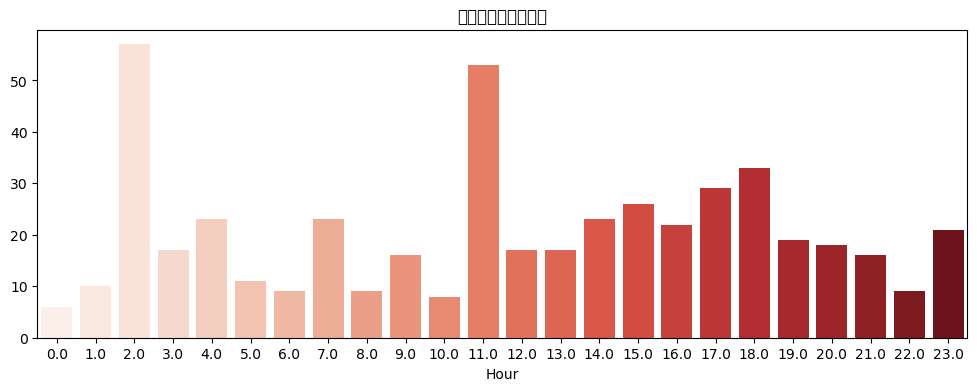

In [9]:
plt.figure(figsize=(12, 4))
fraud_hours = data[data['Class']==1]['Hour'].value_counts().sort_index()
sns.barplot(x=fraud_hours.index, y=fraud_hours.values, palette='Reds')
plt.title('欺诈交易的小时分布')

## 3.2 相关性热图查看特征间关系

C:\Users\avawa\AppData\Local\Temp\ipykernel_9116\1122581387.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y=corr_with_class.index, x=corr_with_class.values, palette='coolwarm')


Text(0.5, 1.0, '特征与Class的相关性排序')

c:\Users\avawa\.conda\envs\ccfd\lib\site-packages\IPython\core\events.py:82: UserWarning: Glyph 29305 (\N{CJK UNIFIED IDEOGRAPH-7279}) missing from font(s) DejaVu Sans.
  func(*args, **kwargs)
c:\Users\avawa\.conda\envs\ccfd\lib\site-packages\IPython\core\events.py:82: UserWarning: Glyph 24449 (\N{CJK UNIFIED IDEOGRAPH-5F81}) missing from font(s) DejaVu Sans.
  func(*args, **kwargs)
c:\Users\avawa\.conda\envs\ccfd\lib\site-packages\IPython\core\events.py:82: UserWarning: Glyph 19982 (\N{CJK UNIFIED IDEOGRAPH-4E0E}) missing from font(s) DejaVu Sans.
  func(*args, **kwargs)
c:\Users\avawa\.conda\envs\ccfd\lib\site-packages\IPython\core\events.py:82: UserWarning: Glyph 30340 (\N{CJK UNIFIED IDEOGRAPH-7684}) missing from font(s) DejaVu Sans.
  func(*args, **kwargs)
c:\Users\avawa\.conda\envs\ccfd\lib\site-packages\IPython\core\events.py:82: UserWarning: Glyph 30456 (\N{CJK UNIFIED IDEOGRAPH-76F8}) missing from font(s) DejaVu Sans.
  func(*args, **kwargs)
c:\Users\avawa\.conda\envs\ccfd\lib

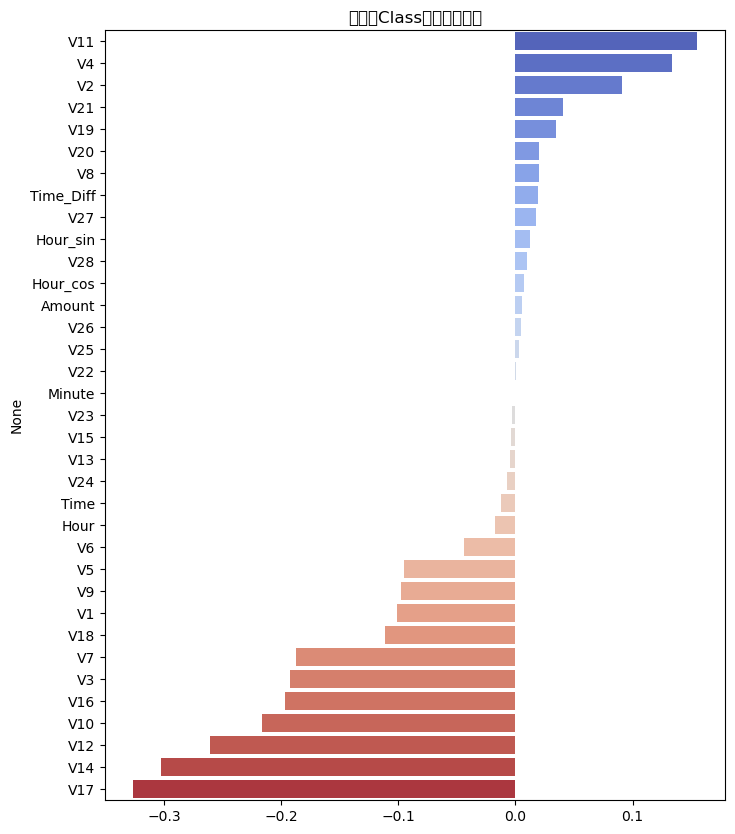

In [11]:
# 排除Class自身
corr_with_class = data.corr()['Class'].drop('Class').sort_values(ascending=False)  

plt.figure(figsize=(8, 10))
sns.barplot(y=corr_with_class.index, x=corr_with_class.values, palette='coolwarm')
plt.title('特征与Class的相关性排序')

# 4 特征工程

## 4.1 特征缩放

In [ ]:
# 对 Amount 特征进行标准化
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
data['Amount'] = scaler.fit_transform(data[['Amount']])

# 对其他特征进行归一化，使用 MinMaxScaler
from sklearn.preprocessing import MinMaxScaler

scaler_minmax = MinMaxScaler()
data_scaled = scaler_minmax.fit_transform(data)

## 4.2 时间序列数据分割

In [ ]:
# 先按时间排序
data_sorted = data.sort_values('Time')

X = data_sorted.drop('Class', axis=1)
y = data_sorted['Class']
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("Training set class distribution:")
print(y_train.value_counts(normalize=True))
print("\nTest set class distribution:")
print(y_test.value_counts(normalize=True))

## 4.3 特征选择

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectFromModel
selector = SelectFromModel(
    LogisticRegression(penalty='l1', solver='liblinear', random_state=42),
    threshold='median'
).fit(X_train, y_train)
selected_features = X_train.columns[selector.get_support()].tolist()

In [ ]:
# 更新数据集
X_train = X_train[selected_features]
X_test = X_test[selected_features]
print(f"最终选择特征：{selected_features}")

## 4.4 处理不平衡数据

In [14]:
# 查看类别分布
class_counts = data['Class'].value_counts()
print(class_counts)

# 查看比例
class_ratios = data['Class'].value_counts(normalize=True)
print(class_ratios)

Class
0    284315
1       492
Name: count, dtype: int64
Class
0    0.998273
1    0.001727
Name: proportion, dtype: float64


In [ ]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# 后续用 X_train_resampled 和 y_train_resampled 替代原训练集
train_data = lgb.Dataset(X_train_resampled, label=y_train_resampled)

In [ ]:
class_weight = len(y_train[y_train==0]) / len(y_train[y_train==1])  # 自动计算权重比

# 5 模型训练与评估

## 5.1 模型训练

### 5.1.1 设置超参数

In [ ]:
import lightgbm as lgb

# 创建 LightGBM 数据集
train_data = lgb.Dataset(X_train, label=y_train)
test_data = lgb.Dataset(X_test, label=y_test)

# 设置参数
params = {
    'objective': 'binary',  # 二分类任务
    'metric': 'binary_logloss', # 评价指标
    'boosting_type': 'gbdt',    # 梯度提升决策树
    
    'boosting_type': 'dart',  # 更适合时间序列
    'time_series': True,      # 启用时间序列模式
    
    'learning_rate': 0.05, # 学习率
    'num_leaves': 31, # 最大叶子节点数
    'max_depth': 6,    # 树的最大深度，防止过拟合
    
    'feature_fraction': 0.8,  # 每次迭代使用的特征比例，防止过拟合
    'bagging_fraction': 0.8,  # 每次迭代使用的数据比例，防止过拟合
    'bagging_freq': 5,  # 每 5 次迭代进行一次 bagging
    
    'lambda_l1': 0.1,  # L1 正则化
    'lambda_l2': 0.2,  # L2 正则化
    
    'min_data_in_leaf': 20,  # 每个叶子节点的最小样本数，防止过拟合
    'min_child_weight': 0.02, # 使一个结点分裂的最小海森值之和
    'max_bin': 255,  # 特征分箱的最大数量，较大的值可以提高精度但会增加计算量
    'verbosity': -1,  # 关闭训练过程中的日志输出
    
    'scale_pos_weight': class_weight,
    'is_unbalance': True  # 或直接启用不平衡模式
}

### 5.1.2 定义AUPRC评估函数

In [17]:
from sklearn.metrics import average_precision_score

# 自定义 AUPRC 评估函数
def auprc_eval(preds, train_data):
    labels = train_data.get_label()  # 获取真实标签
    score = average_precision_score(labels, preds)  # 计算 AUPRC
    return 'auprc', score, True  # 返回指标名称、值和是否越高越好

### 5.1.3 训练模型

In [ ]:
# 训练模型
from lightgbm import early_stopping
from sklearn.model_selection import TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=5)

for fold, (train_idx, val_idx) in enumerate(tscv.split(X_train)):
    X_tr, X_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
    y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]
    
    model = lgb.train(
        params,
        train_data,
        valid_sets=[train_data, test_data],
        valid_names=['train', 'valid'],
        num_boost_round=500,
        callbacks=[early_stopping(stopping_rounds=50)],
        feval=auprc_eval  # 使用自定义 AUPRC 评估函数
    )
    print(f"Fold {fold+1} AUPRC:", calculate_auprc(model, X_val, y_val))

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[98]	train's binary_logloss: 0.000432903	train's auprc: 0.996713	valid's binary_logloss: 0.00233036	valid's auprc: 0.877423


### 5.1.4 对测试集进行预测

In [19]:
# 使用模型对测试集进行预测
y_pred = model.predict(X_test)

## 5.2 模型评估

### 5.2.1 对预测结果进行评估

In [20]:
from sklearn.metrics import precision_recall_curve, auc

# 计算 Precision-Recall 曲线
precision, recall, _ = precision_recall_curve(y_test, y_pred)

# 计算 AUPRC
auprc = auc(recall, precision)
print("Test AUPRC:", auprc)

Test AUPRC: 0.8773098610501813


In [ ]:
from sklearn.metrics import DetCurveDisplay
plt.figure(figsize=(12, 6))

# 新增DET曲线（欺诈检测常用）
DetCurveDisplay.from_predictions(y_test, y_pred)
plt.title("Detection Error Tradeoff (DET) Curve")
plt.grid(True)
plt.show()

# 添加经济影响分析
fraud_cost = y_test * (X_test['Amount'] * 10)  # 假设欺诈损失为金额的10倍
print("潜在欺诈损失减少：${:,.2f}".format(fraud_cost[y_pred > 0.5].sum()))

### 5.2.2 检查 Precision-Recall曲线

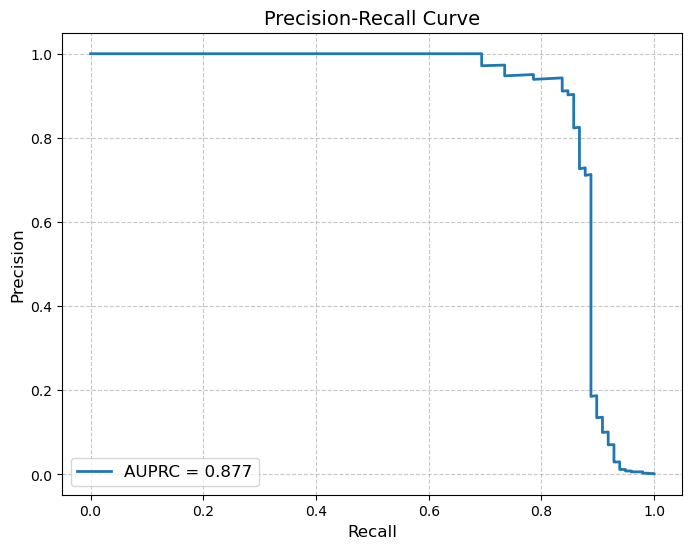

In [21]:
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, label=f"AUPRC = {auprc:.3f}", linewidth=2)
plt.xlabel("Recall", fontsize=12)
plt.ylabel("Precision", fontsize=12)
plt.title("Precision-Recall Curve", fontsize=14)
plt.legend(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

## 5.3 超参数调优

### 5.3.1 max_depth 和 num_leaves

In [22]:
from sklearn.model_selection import GridSearchCV
# 创建 LightGBM 的 sklearn 接口模型
model_lgb = lgb.LGBMClassifier(objective='binary', metric='binary_logloss', random_state=42)

# 定义参数网格
param_grid1 = {
    'max_depth': [4, 6, 8, 10],  # max_depth 的候选值
    'num_leaves': [15, 31, 63, 127]  # num_leaves 的候选值
}

# 使用 GridSearchCV 进行网格搜索
grid_search1 = GridSearchCV(
    estimator=model_lgb,
    param_grid=param_grid1,
    scoring='roc_auc',  # 使用 AUC 作为评估指标
    cv=5,  # 5 折交叉验证
    verbose=1,  # 输出搜索过程
    n_jobs=-1  # 使用所有可用的 CPU 核心
)

# 执行网格搜索
grid_search1.fit(X_train, y_train)

# 输出最佳参数和对应的分数
print("Best parameters found:", grid_search1.best_params_)
print("Best cross-validation AUC score:", grid_search1.best_score_)

Fitting 5 folds for each of 16 candidates, totalling 80 fits
Best parameters found: {'max_depth': 8, 'num_leaves': 31}
Best cross-validation AUC score: 0.7734043249528179


In [23]:
# 输出所有参数组合及其对应的 AUC 分数
results = grid_search1.cv_results_
mean_scores = results['mean_test_score']  # 平均测试分数
params = results['params']  # 参数组合

print("\nAll parameter combinations and their AUC scores:")
for param, score in zip(params, mean_scores):
    print(f"Parameters: {param}, AUC Score: {score}")


All parameter combinations and their AUC scores:
Parameters: {'max_depth': 4, 'num_leaves': 15}, AUC Score: 0.6525658720375322
Parameters: {'max_depth': 4, 'num_leaves': 31}, AUC Score: 0.5616195761087129
Parameters: {'max_depth': 4, 'num_leaves': 63}, AUC Score: 0.5616195761087129
Parameters: {'max_depth': 4, 'num_leaves': 127}, AUC Score: 0.5616195761087129
Parameters: {'max_depth': 6, 'num_leaves': 15}, AUC Score: 0.5529331931303301
Parameters: {'max_depth': 6, 'num_leaves': 31}, AUC Score: 0.6572822858336925
Parameters: {'max_depth': 6, 'num_leaves': 63}, AUC Score: 0.653467301892495
Parameters: {'max_depth': 6, 'num_leaves': 127}, AUC Score: 0.6617663020900625
Parameters: {'max_depth': 8, 'num_leaves': 15}, AUC Score: 0.6501956562006252
Parameters: {'max_depth': 8, 'num_leaves': 31}, AUC Score: 0.7734043249528179
Parameters: {'max_depth': 8, 'num_leaves': 63}, AUC Score: 0.7385862991296974
Parameters: {'max_depth': 8, 'num_leaves': 127}, AUC Score: 0.7655550918083083
Parameters: 

In [24]:
# 定义参数网格
param_grid2 = {
    'max_depth': [9, 10, 11],  # max_depth 的候选值
    'num_leaves': [121, 123, 127, 131, 135]  # num_leaves 的候选值
}

# 使用 GridSearchCV 进行网格搜索
grid_search2 = GridSearchCV(
    estimator=model_lgb,
    param_grid=param_grid2,
    scoring='roc_auc',  # 使用 AUC 作为评估指标
    cv=5,  # 5 折交叉验证
    verbose=1,  # 输出搜索过程
    n_jobs=-1  # 使用所有可用的 CPU 核心
)

# 执行网格搜索
grid_search2.fit(X_train, y_train)

# 输出最佳参数和对应的分数
print("Best parameters found:", grid_search2.best_params_)
print("Best cross-validation AUC score:", grid_search2.best_score_)

Fitting 5 folds for each of 15 candidates, totalling 75 fits
Best parameters found: {'max_depth': 9, 'num_leaves': 123}
Best cross-validation AUC score: 0.7645863861937461


### 5.3.2 min_data_in_leaf 和 min_sum_hessian_in_leaf

In [25]:
# 定义参数网格
param_grid3 = {
    'min_child_samples': [18, 19, 20, 21, 22],  # min_child_samples 的候选值
    'min_child_weight':[0.001, 0.002]  # min_child_weight 的候选值
}

# 使用 GridSearchCV 进行网格搜索
grid_search3 = GridSearchCV(
    estimator=model_lgb,
    param_grid=param_grid3,
    scoring='roc_auc',  # 使用 AUC 作为评估指标
    cv=5,  # 5 折交叉验证
    verbose=1,  # 输出搜索过程
    n_jobs=-1  # 使用所有可用的 CPU 核心
)

# 执行网格搜索
grid_search3.fit(X_train, y_train)

# 输出最佳参数和对应的分数
print("Best parameters found:", grid_search3.best_params_)
print("Best cross-validation AUC score:", grid_search3.best_score_)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best parameters found: {'min_child_samples': 21, 'min_child_weight': 0.002}
Best cross-validation AUC score: 0.8111333752226024


### 5.3.3 feature_fraction 和 bagging_fraction

In [26]:
# 定义参数网格
param_grid4 = {
    'feature_fraction': [0.75, 0.8, 0.85],
    'bagging_fraction': [0.55, 0.6, 0.65]
}

# 使用 GridSearchCV 进行网格搜索
grid_search4 = GridSearchCV(
    estimator=model_lgb,
    param_grid=param_grid4,
    scoring='roc_auc',  # 使用 AUC 作为评估指标
    cv=5,  # 5 折交叉验证
    verbose=1,  # 输出搜索过程
    n_jobs=-1  # 使用所有可用的 CPU 核心
)

# 执行网格搜索
grid_search4.fit(X_train, y_train)

# 输出最佳参数和对应的分数
print("Best parameters found:", grid_search4.best_params_)
print("Best cross-validation AUC score:", grid_search4.best_score_)

Fitting 5 folds for each of 9 candidates, totalling 45 fits
Best parameters found: {'bagging_fraction': 0.55, 'feature_fraction': 0.75}
Best cross-validation AUC score: 0.7911115678184005


### 5.3.4 正则化参数

In [27]:
# 定义参数网格
param_grid5 = {
    'lambda_l1': [0, 0.001, 0.01, 0.03, 0.08, 0.3, 0.5],
    'lambda_l2': [0, 0.001, 0.01, 0.03, 0.08, 0.3, 0.5]
}

# 使用 GridSearchCV 进行网格搜索
grid_search5 = GridSearchCV(
    estimator=model_lgb,
    param_grid=param_grid5,
    scoring='roc_auc',  # 使用 AUC 作为评估指标
    cv=5,  # 5 折交叉验证
    verbose=1,  # 输出搜索过程
    n_jobs=-1  # 使用所有可用的 CPU 核心
)

# 执行网格搜索
grid_search5.fit(X_train, y_train)

# 输出最佳参数和对应的分数
print("Best parameters found:", grid_search5.best_params_)
print("Best cross-validation AUC score:", grid_search5.best_score_)

Fitting 5 folds for each of 49 candidates, totalling 245 fits
Best parameters found: {'lambda_l1': 0, 'lambda_l2': 0.5}
Best cross-validation AUC score: 0.9844627881261765


In [28]:
# 定义更精细的参数网格
param_grid_6 = {
    'lambda_l1': [0.0005, 0.001, 0.002, 0.005],
    'lambda_l2': [0.4, 0.45, 0.5, 0.55, 0.6]
}

# 使用 GridSearchCV 进行更精细的网格搜索
grid_search_6 = GridSearchCV(
    estimator=model_lgb,
    param_grid=param_grid_6,
    scoring='roc_auc',
    cv=5,
    verbose=1,
    n_jobs=-1
)

# 执行网格搜索
grid_search_6.fit(X_train, y_train)

# 输出最佳参数和对应的分数
print("Refined best parameters found:", grid_search_6.best_params_)
print("Refined best cross-validation AUC score:", grid_search_6.best_score_)

Fitting 5 folds for each of 20 candidates, totalling 100 fits
Refined best parameters found: {'lambda_l1': 0.0005, 'lambda_l2': 0.6}
Refined best cross-validation AUC score: 0.986332264940247


## 5.4 尝试降低 learning_rate

In [30]:
# 设置参数
params_refined = {
    'objective': 'binary',  # 二分类任务
    'metric': 'binary_logloss', # 评价指标
    'boosting_type': 'gbdt',    # 梯度提升决策树
    
    'learning_rate': 0.005, # 学习率
    'num_leaves': 31, # 最大叶子节点数
    'max_depth': 8,    # 树的最大深度，防止过拟合
    
    'feature_fraction': 0.75,  # 每次迭代使用的特征比例，防止过拟合
    'bagging_fraction': 0.55,  # 每次迭代使用的数据比例，防止过拟合
    'bagging_freq': 5,  # 每 5 次迭代进行一次 bagging
    
    'lambda_l1': 0.0005,  # L1 正则化
    'lambda_l2': 0.6,  # L2 正则化
    
    'min_data_in_leaf': 21,  # 每个叶子节点的最小样本数，防止过拟合
    'min_child_weight': 0.002, # 使一个结点分裂的最小海森值之和
    'max_bin': 255,  # 特征分箱的最大数量，较大的值可以提高精度但会增加计算量
    'verbosity': -1  # 关闭训练过程中的日志输出
}

In [31]:
model_refined = lgb.train(
    params_refined,
    train_data,
    valid_sets=[train_data, test_data],
    valid_names=['train', 'valid'],
    num_boost_round=500,
    callbacks=[early_stopping(stopping_rounds=50)],
    feval=auprc_eval  # 使用自定义 AUPRC 评估函数
)

Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[500]	train's binary_logloss: 0.00131777	train's auprc: 0.970809	valid's binary_logloss: 0.00257238	valid's auprc: 0.869215


In [32]:
# 使用模型对测试集进行预测
y_pred_refined = model_refined.predict(X_test)

In [33]:
# 计算 Precision-Recall 曲线
precision_1, recall_1, _ = precision_recall_curve(y_test, y_pred_refined)

# 计算 AUPRC
auprc = auc(recall_1, precision_1)
print("Test AUPRC:", auprc)

Test AUPRC: 0.8690499487081494


## 5.5 保存和部署

In [34]:
import joblib

# 保存模型到文件
joblib.dump(model, "lgb_optimized_model.pkl")
print("模型已保存为 lgb_optimized_model.pkl")

模型已保存为 lgb_optimized_model.pkl


# 6 可解释性分析

In [40]:
# 定义测试数据和选择的特征
test_df = X_test  # 使用测试集作为分析数据
selected_features = X_test.columns.tolist()  

In [41]:
# SHAP值分析
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(test_df[selected_features])

c:\Users\avawa\.conda\envs\ccfd\lib\site-packages\shap\explainers\_tree.py:544: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


In [42]:
# 检查 shap_values 的结构
print(f"shap_values type: {type(shap_values)}")
if isinstance(shap_values, list):
    print(f"shap_values[0] shape: {shap_values[0].shape}")
    print(f"shap_values[1] shape: {shap_values[1].shape}")

shap_values type: <class 'numpy.ndarray'>


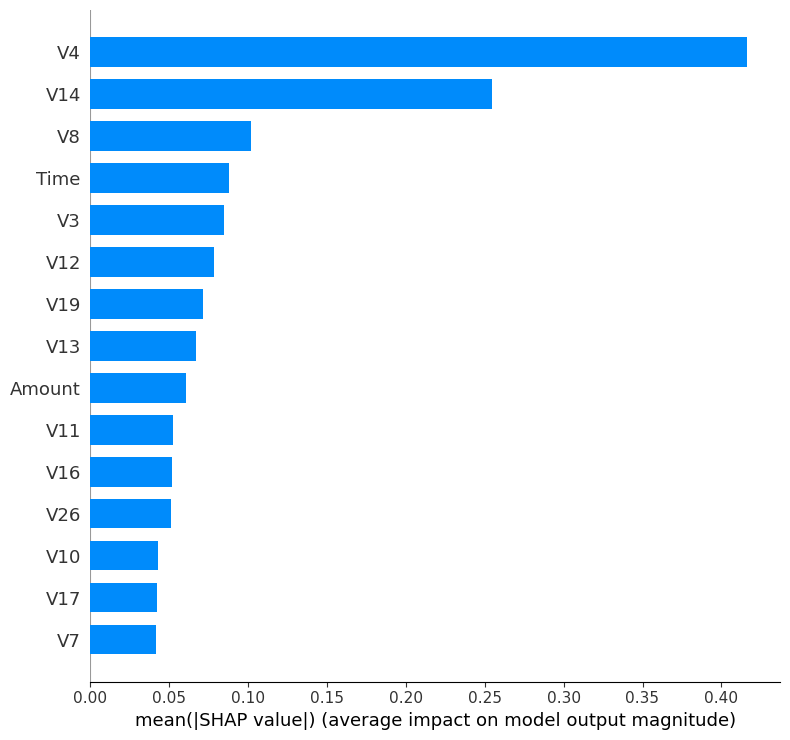

In [43]:
# 绘制 SHAP summary plot
plt.figure(figsize=(10, 6))
if isinstance(shap_values, list):
    # 如果是列表，选择正类（通常是 shap_values[1]）
    shap.summary_plot(shap_values[1], test_df[selected_features], plot_type='bar', max_display=15)
else:
    # 如果是单个 ndarray，直接使用
    shap.summary_plot(shap_values, test_df[selected_features], plot_type='bar', max_display=15)